In [1]:
!pip install torch-geometric
!pip install obonet
!pip install torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=545106 sha256=09eab81d616d12ed52d9284adb5ccfae2addcbb887a6533985ee06326882dab4
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter


### Model and propagation layers
For propagation, we can chose between GCN and DAG layers. GCN is standard graph convolution and DAG aggregated information in leaf to node way, which can be thought of as a special case of GNNs.

In [104]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import numpy as np
from torch_scatter import scatter, scatter_add

import torch
from torch import Tensor
from torch.nn import Linear, Parameter
from torch.nn import functional as F
from torch_geometric.nn import MessagePassing
import networkx as nx
from torch_geometric.typing import Adj, OptTensor, Size
from torch_geometric.utils.num_nodes import maybe_num_nodes
from typing import Union, Tuple, Callable

class DAGProp(torch.nn.Module):
    r"""
    DAG propagation layer. - for aggregating the information in the ontology classes graph
    based on leaf to node aggregation

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        nonlinearity (torch.nn.functional, optional): The nonlinearity to use.
            (default: :obj:`torch.tanh`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, root_weight: bool = True,
                 bias: bool = True, nonlinearity: Callable = torch.tanh, aggr: str = "mean",**kwargs):
        super(DAGProp, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.root_weight = root_weight
        self.nonlinearity = nonlinearity
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def is_cyclic(self, edge_index):
        graph = nx.DiGraph()
        # Add edges to the graph based on edge_index
        for i in range(edge_index.size(1)):
            source = edge_index[0, i].item()
            target = edge_index[1, i].item()
            graph.add_edge(source, target)

        return nx.is_directed_acyclic_graph(graph)

    def forward(self, x: Tensor, edge_index: Adj, batch: OptTensor = None ,
                size: Size = None) -> Tensor:

        # check if the graph is acyclic if not return an error
        if not self.is_cyclic(edge_index):
            raise ValueError("The graph is cyclic")

        num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
        batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()

        total_nodes = x.size(0)
        num_edges_ref = edge_index.shape[1] // batch_size

        out = x.new_zeros(x.size())
        visited = x.new_zeros(size=(x.size(0),),dtype=torch.int16)

        #1. Start propagation from the leaves

        leaves = torch.where(scatter(src=edge_index.new_ones(edge_index[1,:].size(),dtype=torch.int8),
                            index=edge_index[1,:], dim_size=num_nodes, reduce="sum")==0)[0]
        out[leaves] = self.nonlinearity(x[leaves])
        visited[leaves]=1

        #2. Compute self-nodes processing

        if self.root_weight:
            temp = x[leaves]
            x[leaves] = 0
            mask = x.nonzero(as_tuple=True)[0]
            x[leaves] = temp
            out[mask] = self.lin_r(x[mask])

        #3. Update the embedding of the other nodes

        previous_visits = leaves[leaves < max_num_nodes]
        adj_mat_cropped = edge_index[:,:num_edges_ref]
        while torch.sum(visited)!=visited.shape[0]:
            mask=(adj_mat_cropped[0,:][..., None] == previous_visits).any(-1)
            fathers = torch.unique(adj_mat_cropped[1,mask])
            del mask
            mask=(adj_mat_cropped[1,:][..., None]== fathers).any(-1)
            mask1=scatter(src=visited[adj_mat_cropped[0,mask]], index=adj_mat_cropped[1,mask], reduce="sum")
            mask1=mask1[fathers]
            mask2=scatter(src=visited.new_ones(size=visited[adj_mat_cropped[0,mask]].size(),dtype=torch.int16), index=adj_mat_cropped[1,mask], reduce="sum")
            mask2=mask2[fathers]
            ref_next_visits = fathers[mask1==mask2]
            del mask
            mask = (adj_mat_cropped[1,:][..., None] == ref_next_visits).any(-1)
            adj_mat = [adj_mat_cropped[:,mask] + i*max_num_nodes for i in range(batch_size)]
            adj_mat = torch.cat(adj_mat, dim=1)
            next_visits = [ref_next_visits + i*max_num_nodes for i in range(batch_size)]
            next_visits = torch.cat(next_visits, dim=0)
            mask = adj_mat[0,:]
            children = out[mask]#.view(-1)
            if len(children)>1:
                out[next_visits] += self.lin_l(children.sum(dim=0))
            else:
                out[next_visits] += self.lin_l(children)
            out[next_visits] = self.nonlinearity(out[next_visits])
            previous_visits = ref_next_visits
            visited[next_visits]=1

        return out

    def __repr__(self):
        return '{}({}, {}, aggr={}, nonlinearity={})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels,self.aggr,self.nonlinearity.__name__)

class TopSelection(torch.nn.Module):
    """Top selection for pooling layer used in GraphGONet (please refer to the Methods part in the paper for mathematical explanations)

    Args:
        in_channels (int): number of input channels
        ratio (Union[float, int], optional): ratio of genes that should be kept. Defaults to 0.5.
    """

    def __init__(self, in_channels: int, ratio: Union[float, int] = 0.5, **kwargs):

        super(TopSelection, self).__init__()

        self.in_channels = in_channels
        self.ratio = Parameter(torch.tensor(ratio, dtype=torch.float32), requires_grad=True)

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        """Runs the forward pass of the module.

        Args:
            x (torch.Tensor): The node feature matrix.
            edge_index (torch.Tensor): The edge indices.
            edge_attr (torch.Tensor, optional): The edge features. Defaults to None.
            batch (torch.Tensor, optional): The batch vector. Defaults to None.
        """
        # Apply topk along dimension 1 (features)
        num_features_to_keep = int(self.ratio * x.shape[1])  # Calculate number of features to keep
        _, topk_indices = torch.topk(x.abs(), num_features_to_keep, dim=1)  # Get indices of topk features

        # Create a mask to select topk features and set others to 0
        mask = torch.zeros_like(x, dtype=torch.bool)  # Initialize mask with all False
        for i, indices in enumerate(topk_indices):
            mask[i, indices] = True  # Set True for topk features in each row

        # Apply the mask to the input tensor x
        x = x * mask.type(x.dtype)  # Multiply x by the mask to keep topk and set others to 0

        return x  # Return the modified tensor

    def __repr__(self):
        return "{}({}, ratio={})".format(
            self.__class__.__name__, self.in_channels, self.ratio
        )


class GCNPropagation(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) propagation layer. - for aggregating the information in the ontology classes graph

    Args:
        in_channels (int): Number of input channels (node feature dimensionality).
        out_channels (int): Number of output channels (node feature dimensionality after propagation).
        aggr (str): Aggregation method for neighborhood information (default: 'mean').
    """

    def __init__(self, in_channels, out_channels, aggr="mean"):
        super(GCNPropagation, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        #self.conv2 = GCNConv(in_channels*12, out_channels)

    def forward(self, x, edge_index, batch=None):
        """
        Forward pass for the GCN propagation layer.

        Args:
            x (torch.Tensor): Node feature matrix of shape [num_nodes, in_channels].
            edge_index (torch.Tensor): Graph connectivity in COO format of shape [2, num_edges].
            batch (torch.Tensor): Batch indices for graph-level tasks (optional).

        Returns:
            torch.Tensor: Updated node features of shape [num_nodes, out_channels].
        """
        # Apply GCN convolution
        x = self.conv1(x, edge_index)
        # Apply ReLU activation
        x = F.relu(x)

        return x

class OntologyNN(nn.Module):
    """
    PyTorch neural network model using tabular data and an ontology graph.
    This model integrates feature data with graph propagation through GNN layers.

    Args:
        n_features (int): Number of input features (e.g., F1, F3, F4, F5).
        n_nodes (int): Total number of nodes in the ontology graph (features + ontology terms).
        n_nodes_annot (int): Number of nodes with initial embeddings (features).
        n_nodes_emb (int): Number of nodes with embeddings after propagation.
        n_prop1 (int): Number of channels for the first propagation layer.
        adj_mat_fc1 (torch.Tensor): Adjacency matrix for feature-to-node connections.
        propagation (str): Propagation method for graph convolution (default: 'GCNConv').
    """

    def __init__(
        self,
        n_features,
        n_nodes,
        n_nodes_annot,
        n_nodes_emb,
        n_prop1,
        adj_mat_fc1,
        propagation="GCNPropagation",
        selection=None,
        ratio=1.0,
        out_channels=1,
        out_activation=None,
        task='regression',
        dropout_rate=0.3
    ):
        super(OntologyNN, self).__init__()

        # Store the input parameters
        self.n_features = n_features
        self.n_nodes = n_nodes
        self.n_nodes_annot = n_nodes_annot
        self.n_nodes_emb = n_nodes_emb
        self.n_prop1 = n_prop1
        self.out_channels = out_channels
        self.out_activation = out_activation
        self.task = task
        self.propagation = propagation

        if selection:
            self.ratio = ratio
            if selection == "top":
                self.selection = TopSelection(in_channels=n_nodes, ratio=ratio)
        else:
            self.selection = None


        # Convert adjacency matrix to a non-trainable torch tensor
        adj_mat_fc1 = torch.tensor(adj_mat_fc1, dtype=torch.float).t()
        self.adj_mat_fc1 = Parameter(adj_mat_fc1, requires_grad=False)

        # Define the first fully connected layer (feature to node mapping)
        self.fc1 = Linear(in_features=n_features, out_features=n_nodes_annot)

        #Apply the mask to the weights of the first layer
        with torch.no_grad():
            self.fc1.weight.mul_(self.adj_mat_fc1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.dag_prop = DAGProp(in_channels=n_prop1, out_channels=n_prop1)

        self.gcn_prop = GCNPropagation(in_channels=n_nodes, out_channels=n_nodes)
        # Define the graph propagation layer
        # self.propagation = eval(propagation)(
        #     in_channels=n_prop1, out_channels=n_prop1
        # )

        # Define the final fully connected layer for income prediction
        self.fc2 = Linear(in_features=n_nodes, out_features=out_channels)

    def forward(self, feature_data, graph_data):
        """Runs the forward pass of the module."""
        x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch

        # Initialize the node embeddings from the feature data using the fc1 layer
        initial_embedding = self.fc1(feature_data)

        #Added ReLU activation after fc1 layer
        x = initial_embedding
        # x = self.relu(x)

        if self.propagation == "DAGProp":
            num_data_samples, num_nodes = x.shape
            out = x.new_zeros(x.shape)
            for i in range(num_data_samples):
                # Extract features for the current sample (shape: (num_nodes,))
                x_sample = x[i].unsqueeze(1)
                # # Apply DAG propagation on the current sample
                out_sample = self.dag_prop(x_sample, edge_index, batch)
                out[i] = out_sample.squeeze(1)

            x = out
        elif self.propagation == "GCNPropagation":
            x = self.gcn_prop(x, edge_index, batch)

        if self.selection:
            x = self.selection(x, edge_index)

        # x = self.dropout(x)

        # Aggregate node representations using global mean pooling
        # x = global_mean_pool(x, batch)

        # Aggregate all information with the last fc layer
        x = self.fc2(x)

        if self.task == 'classification':
          if self.out_channels == 1:
            #x = self.relu(x)
            x = torch.sigmoid(x)
          else:
            #x = self.relu(x)
            x = F.softmax(x, dim=1)
        elif self.task == 'regression':
            x = self.relu(x)
        if self.out_channels >=2:
          return x
        else:
          return x.view(-1)  # Return a 1D tensor of predictions

def interpret(model, edge_index, ontology_keys, sample_index=None):

    """
    Returns relevance scores for the ontology classes for a sample data prediction, or the +/- frequency of each class if all data is evaluated.

    Args:
        model: the trained model.
        edge_index: edge index for the ontology graph.
        feature_data_test: feature data for the test set
        ontology_keys (list): list of ontology classes.
        sample_index (int, optional): index of the sample data point to interpret. If None, interpret all samples from test set. Defaults to None.

    """



    # Get activations for a sample data point
    if sample_index:
        sample_index = sample_index  # Choose the index of the sample data point
        sample_data = feature_data_test[sample_index].unsqueeze(0)
    else:
        sample_data = feature_data_test

    # Create the graph data for the sample
    graph_data = Data(
        x=torch.ones(model.n_nodes, model.n_nodes_emb),
        edge_index=edge_index,
        batch=torch.zeros(model.n_nodes, dtype=torch.int64)
    )

    # Perform a forward pass to get activations
    with torch.no_grad():
        model.eval()
        activations = model(sample_data, graph_data)

        # Access the activations of specific layers
        # Example: Get the activations of the first fully connected layer
        # Replace 'model.fc1' with the desired layer name from your model architecture
        fc1_activations = model.fc1(sample_data)
        # print("FC1 activations:", fc1_activations)

        # Example: Get the output of the propagation layer
        x = model.fc1(sample_data)
        out = x.new_zeros(x.shape)
        for i in range(sample_data.shape[0]):
            # Extract features for the current sample
            x_sample = x[i].unsqueeze(1)
            # Apply DAG propagation on the current sample
            out_sample = model.dag_prop(x_sample, edge_index, sample_graph_data.batch)
            out[i] = out_sample.squeeze(1)

        if model.selection:
            out = model.selection(out, edge_index)

        fc2_activations = model.fc2(out)

    ontology_dict = {}
    for i, key in enumerate(ontology_keys):
      ontology_dict[key] = {
          'count': 0,
          'positive': 0,
          'negative': 0
      }

    for i in range(len(out)):
        scores = out[i]*model.fc2.weight[1]

        for j, key in enumerate(ontology_keys):
            ontology_dict[key] = {
                'count': ontology_dict[key]['count']+1 if scores[j] != 0 else ontology_dict[key]['count']+0,
                'positive': ontology_dict[key]['positive']+1 if scores[j] > 0 else ontology_dict[key]['positive']+0,
                'negative': ontology_dict[key]['negative']+1 if scores[j] < 0 else ontology_dict[key]['negative']+0
            }

    # Sort the ontology keys based on relevance scores in descending order
    if sample_index:
        sorted_ontology_mapping = sorted(zip(ontology_keys, scores), reverse=True)

        for key, relevance in sorted_ontology_mapping:
            print(f"{key}: {relevance}")
    else:
        print(ontology_dict)

        data = ontology_dict
        categories = list(data.keys())
        positive_counts = [data[category]['positive'] for category in categories]
        negative_counts = [data[category]['negative'] for category in categories]

        width = 0.5

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.barh(categories, positive_counts, width, label='Positive', color='skyblue')
        ax.barh(categories, negative_counts, width, left=positive_counts, label='Negative', color='coral')

        ax.set_xlabel('Counts')
        ax.set_ylabel('Categories')
        ax.set_title('Positive and Negative Counts per Category')
        ax.legend()

        plt.show()

### Training on a toy dataset for regression - predicting income from other features

#### Ontology used: 3-high level classes: "Seniority", "Experience Level", "Qualification"

#### the features are linked to classes as follows:
Age -> Seniority,

Age -> Experience Level,

Education -> Qualification,

Experience -> Seniority,

Experience -> Experience level

#### and the classes are linked among themselves as:
"Seniority"->"Experience Level"

"Seniority"->"Qualification"

***Note that this is meant just for testing, this simple ontology may not make sense at all :D***

In [ ]:
import pandas as pd

# Sample data
data = {
    'income': [50000, 60000, 70000, 80000, 90000],
    'age': [25, 30, 35, 40, 45],
    'education': [12, 16, 18, 20, 22],
    'experience': [2, 5, 8, 10, 12],
    'location': ['Urban', 'Suburban', 'Rural', 'Urban', 'Suburban']
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df

,income,age,education,experience,location
0,50000,25,12,2,Urban
1,60000,30,16,5,Suburban
2,70000,35,18,8,Rural
3,80000,40,20,10,Urban
4,90000,45,22,12,Suburban


In [ ]:
# prompt: label encode the location column

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder on the 'location' column
le.fit(df['location'])

# Transform the 'location' column
df['location'] = le.transform(df['location'])

# Print the updated DataFrame
df

,income,age,education,experience,location
0,50000,25,12,2,2
1,60000,30,16,5,1
2,70000,35,18,8,0
3,80000,40,20,10,2
4,90000,45,22,12,1


In [ ]:
# prompt: create an ontology with three classes and define relationship with features through a matrix with shape (num_features*classes)

import numpy as np

# Define the ontology classes
classes = ["Seniority", "Experience Level", "Qualification"]

# Define the features
features = ["age", "education", "experience", "location"]

# Create the relationship matrix (num_features * num_classes)
relationship_matrix = np.zeros((len(features), len(classes)))

# Define the relationships between features and classes
# Example: Age is related to Seniority and Experience Level
relationship_matrix[0, 0] = 1  # Age -> Seniority
relationship_matrix[0, 1] = 1  # Age -> Experience Level
relationship_matrix[1,2] = 1 # Education -> Qualification
relationship_matrix[2, 0] = 1 # Experience -> Seniority
relationship_matrix[2, 1] = 1 # Experience -> Experience level
relationship_matrix[3, 0] = 1

relationship_matrix

array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 1., 0.],
       [1., 0., 0.]])

In [ ]:
# model training
n_nodes = len(classes)
n_nodes_emb = len(classes)
n_features = len(features)
n_nodes_annot = len(classes)
n_prop1 = 1

feature_data = torch.Tensor(df[features].values)#torch.randn(3, n_features)  # 5 instances, 4 features
graph_data = Data(
    x=torch.ones(n_nodes, n_nodes_emb),  # Node features
    edge_index=torch.tensor([[0, 1], [1, 2]], dtype=torch.long),  # Edges
    batch=torch.tensor([0, 0, 0]),  # Batch index
)

# Create the model
model = OntologyNN(
    n_features=n_features,
    n_nodes=n_nodes,
    n_nodes_annot=n_nodes_annot,
    n_nodes_emb=n_nodes_emb,
    n_prop1=n_prop1,
    adj_mat_fc1=relationship_matrix,
    propagation="DAGProp"
)

# Define loss function and optimizer
criterion = torch.nn.MSELoss() # Example loss function, adjust as needed
optimizer = torch.optim.Adam(model.parameters(), lr=0.04) # Example optimizer


all_loss = []
# Training loop
epochs = 1000
for epoch in range(epochs):
  optimizer.zero_grad()
  output = model(feature_data, graph_data)

  #Example target, replace with your actual target
  target = torch.Tensor(df['income'].values)
  loss = criterion(output, target)
  if epoch % 10 == 0:
    all_loss.append(loss.item())
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 50 == 0:
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

output

Epoch [50/1000], Loss: 5098939904.0000
Epoch [100/1000], Loss: 5097512960.0000
Epoch [150/1000], Loss: 5096688128.0000
Epoch [200/1000], Loss: 5094794240.0000
Epoch [250/1000], Loss: 5093538304.0000
Epoch [300/1000], Loss: 5092609024.0000
Epoch [350/1000], Loss: 5092336640.0000
Epoch [400/1000], Loss: 5089487872.0000
Epoch [450/1000], Loss: 5089553408.0000
Epoch [500/1000], Loss: 5085428736.0000
Epoch [550/1000], Loss: 5089290752.0000
Epoch [600/1000], Loss: 5084996608.0000
Epoch [650/1000], Loss: 5085059584.0000
Epoch [700/1000], Loss: 5085448704.0000
Epoch [750/1000], Loss: 5084327936.0000
Epoch [800/1000], Loss: 5080466432.0000
Epoch [850/1000], Loss: 5080415744.0000
Epoch [900/1000], Loss: 5078672384.0000
Epoch [950/1000], Loss: 5078966784.0000
Epoch [1000/1000], Loss: 5076980736.0000


tensor([150.4493, 150.2856, 150.4493, 150.4581, 205.6215],
       grad_fn=<ViewBackward0>)

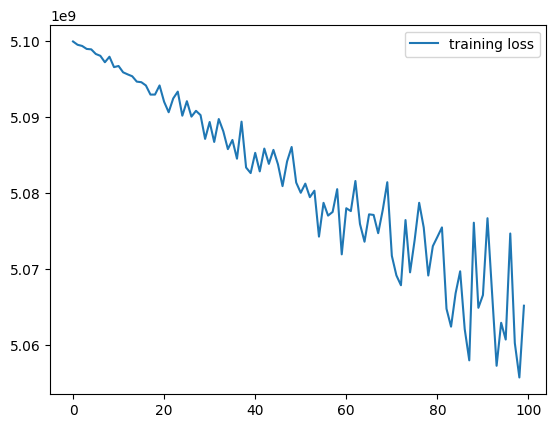

In [ ]:
from matplotlib import pyplot as plt
plt.plot(all_loss, label='training loss')
plt.legend()

### Training on titanic data for classification task (predicting survival based on features)

ontology (class-feature mapping):

    'Passenger':[],
    'Class': ['Pclass'],
    'Demographics': ['Sex', 'Age'],
    'Family': ['SibSp', 'Parch'],
    'Ticket': ['Fare'],
    'Cabin': ['CabinClass'],
    'Embarkation': ['Embarked']

where 'Passenger', 'Class', 'Demographics', 'Family', 'Ticket', 'Cabin', 'Embarkation' are classes

and these classes are linked as

[Passenger] --(has)--> [Class]

[Passenger] --(has)--> [Demographics]

[Passenger] --(has)--> [Family]

[Passenger] --(has)--> [Cabin]

[Passenger] --(has)--> [Embarkation]

[Class] --(influences)--> [Cabin]

[Class] --(influences)--> [Fare]

[Demographics] --(influences)--> [Family]

[Cabin] --(related to)--> [Class]

[Embarkation] --(related to)--> [Class]


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load Titanic dataset
data = pd.read_csv("titanic.csv")

# Select relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'CabinClass']
target = 'Survived'

# Handle missing values
data.dropna(inplace=True)

# Encode categorical variables
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'].astype(str))

# # Scale numerical values
scaler = StandardScaler()
data[['Age', 'Fare']] = scaler.fit_transform(data[['Age', 'Fare']])
# Extract cabin class
def extract_cabin_class(cabin):
    if pd.isna(cabin):
        return 'Unknown'  # Handle missing values
    else:
        return cabin[0]  # Extract the first letter

# Apply the function to the 'Cabin' column
data['CabinClass'] = data['Cabin'].apply(extract_cabin_class)
data['CabinClass'] = le.fit_transform(data['CabinClass'])

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinClass
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.149065,1,0,PC 17599,-0.097180,C85,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,-0.043230,1,0,113803,-0.335997,C123,2,2
6,7,0,1,"McCarthy, Mr. Timothy J",1,1.174636,0,0,17463,-0.352250,E46,2,4
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",0,-2.030273,1,1,PP 9549,-0.814070,G6,2,6
11,12,1,1,"Bonnell, Miss. Elizabeth",0,1.431029,0,0,113783,-0.684702,C103,2,2


In [8]:
# prompt: map the features in the following way, ignore the description :
# Dataset Feature	Ontological Node	Description
# Pclass	Class	Socio-economic status (1 = 1st class, 2 = 2nd class, 3 = 3rd class).
# Sex	Demographics	Gender of the passenger (male/female).
# Age	Demographics	Age of the passenger.
# SibSp	Family	Number of siblings/spouses aboard.
# Parch	Family	Number of parents/children aboard.
# Fare	Ticket	Fare paid for the ticket.
# CabinClass	Cabin	Cabin class (if available).
# Embarked	Embarkation	Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

# Map features to ontology nodes
ontology_mapping = {
    'Passenger':[],
    'Class': ['Pclass'],
    'Demographics': ['Sex', 'Age'],
    'Family': ['SibSp', 'Parch'],
    'Ticket': ['Fare'],
    'Cabin': ['CabinClass'],
    'Embarkation': ['Embarked']
}

n_features = len(features)
n_nodes = len(ontology_mapping) # Number of ontological nodes

adj_mat_fc1 = np.zeros((n_features, n_nodes))

# Assign connections based on the provided mapping
feature_to_node_index = {feature: i for i, feature in enumerate(features)}
node_to_index = {node: i for i, node in enumerate(ontology_mapping)}

for feature, node_list in ontology_mapping.items():
    for feature_name in node_list:
        if feature_name in feature_to_node_index:
            adj_mat_fc1[feature_to_node_index[feature_name], node_to_index[feature]] = 1

adj_mat_fc1


array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [ ]:
# Passenger] --(has)--> [Class]
# [Passenger] --(has)--> [Demographics]
# [Passenger] --(has)--> [Family]
# [Passenger] --(has)--> [Cabin]
# [Passenger] --(has)--> [Embarkation]

# [Class] --(influences)--> [Cabin]
# [Class] --(influences)--> [Fare]

# [Demographics] --(influences)--> [Family]

# [Cabin] --(related to)--> [Class]

# [Embarkation] --(related to)--> [Class]

In [9]:
# prompt: create edge index for ontology nodes based on above links

import torch

# Define the ontology relationships as a list of tuples (source_node, target_node)
ontology_relationships = [
    (0, 1),  # Passenger -> Class
    (0, 2),  # Passenger -> Demographics
    (0, 3),  # Passenger -> Family
    (0, 5),  # Passenger -> Cabin
    (0, 6),  # Passenger -> Embarkation
    (1, 5),  # Class -> Cabin
    (1, 4),  # Class -> Ticket (Fare)
    (2, 3),  # Demographics -> Family
    # (5, 1),  # Cabin -> Class
    (6, 1),  # Embarkation -> Class
]

# Create the edge index from the ontology relationships
edge_index = torch.tensor(ontology_relationships, dtype=torch.long).t().contiguous()

# # Now you can use 'edge_index' in your graph data object
# graph_data = Data(
#     x=torch.ones(n_nodes, n_nodes_emb),  # Node features (replace with your actual node features)
#     edge_index=edge_index,  # Edges
#     batch=torch.arange(len(X_train)),  # Batch index (Adjust if necessary)
# )
edge_index

tensor([[0, 0, 0, 0, 0, 1, 1, 2, 6],
        [1, 2, 3, 5, 6, 5, 4, 3, 1]])

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [50/500], Train Loss: 0.5574, Test Loss: 0.5426
Epoch [100/500], Train Loss: 0.5148, Test Loss: 0.5255
Epoch [150/500], Train Loss: 0.5066, Test Loss: 0.5269
Epoch [200/500], Train Loss: 0.5040, Test Loss: 0.5295
Epoch [250/500], Train Loss: 0.5020, Test Loss: 0.5310
Epoch [300/500], Train Loss: 0.5013, Test Loss: 0.5316
Epoch [350/500], Train Loss: 0.4942, Test Loss: 0.5317
Epoch [400/500], Train Loss: 0.5009, Test Loss: 0.5318
Epoch [450/500], Train Loss: 0.4939, Test Loss: 0.5318
Epoch [500/500], Train Loss: 0.5007, Test Loss: 0.5318


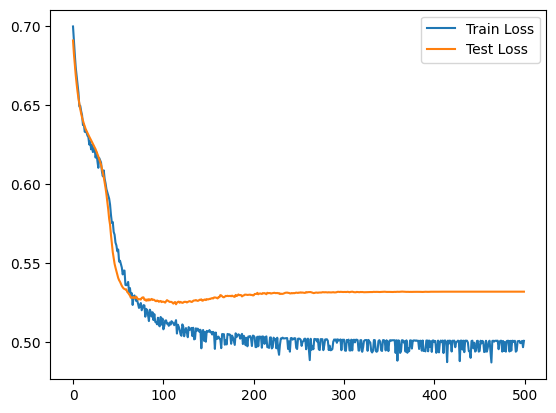

In [16]:
# model training

from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch_geometric.data import Data, Batch

np.random.seed(42)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data['Survived'], test_size=0.2, random_state=42
)

# Convert to tensors
feature_data_train = torch.Tensor(X_train.values)
feature_data_test = torch.Tensor(X_test.values)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Batch size
batch_size = 16

# Create custom datasets and data loaders for batching
train_dataset = TensorDataset(feature_data_train, y_train_tensor)
test_dataset = TensorDataset(feature_data_test, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# # Function to create batched graph data
# def create_graph_batch(batch_size, edge_index, n_nodes_emb):
#     return Batch.from_data_list([
#         Data(x=torch.ones(n_nodes_emb, n_nodes_emb), edge_index=edge_index) for _ in range(batch_size)
#     ])

n_features = len(features)
n_nodes = len(ontology_mapping)
n_nodes_emb = len(ontology_mapping)
n_nodes_annot = len(ontology_mapping)

# Create the model
model = OntologyNN(
    n_features=feature_data_train.shape[1],
    n_nodes=len(ontology_mapping.keys()),
    n_nodes_annot=len(ontology_mapping.keys()),
    n_nodes_emb=len(ontology_mapping.keys()),
    n_prop1=1,
    adj_mat_fc1=adj_mat_fc1,
    propagation="DAGProp", #GCNPropagation #DAGProp
    selection='top',
    ratio=1.0,
    out_channels=2,
    out_activation=None,
    task='classification',
    dropout_rate=0.3
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5, verbose=True)

train_losses = []
test_losses = []

# Training loop with batches
epochs = 500
for epoch in range(epochs):
    model.train()
    batch_train_loss = 0
    for feature_batch, target_batch in train_loader:
        optimizer.zero_grad()

        # Create batched graph data
        graph_data_batch = Data(
            x=torch.ones(n_nodes, n_nodes_emb),
            edge_index=edge_index,
            #batch=torch.arange(len(feature_batch)),
            batch=torch.zeros(n_nodes, dtype=torch.int64)
        )

        # Forward pass
        output_batch = model(feature_batch, graph_data_batch)
        loss = criterion(output_batch, target_batch)
        loss.backward()
        optimizer.step()

        batch_train_loss += loss.item()

    train_losses.append(batch_train_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    batch_test_loss = 0
    with torch.no_grad():
        for feature_batch, target_batch in test_loader:
            #graph_batch = create_graph_batch(len(feature_batch), edge_index, len(ontology_mapping.keys()))
            graph_data_batch = Data(
              x=torch.ones(n_nodes, n_nodes_emb),
              edge_index=edge_index,
              #batch=torch.arange(len(feature_batch)),
              batch=torch.zeros(n_nodes, dtype=torch.int64)
              )

            output_batch = model(feature_batch, graph_data_batch)
            loss = criterion(output_batch, target_batch)
            batch_test_loss += loss.item()

    test_losses.append(batch_test_loss / len(test_loader))

    scheduler.step(batch_test_loss / len(test_loader))

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()


In [17]:
# prompt: print the accuracy of predictions for train and test set

from sklearn.metrics import accuracy_score

# Predictions on the training set
with torch.no_grad():
    train_predictions = model(feature_data_train, graph_data_batch)
    train_predicted_labels = torch.argmax(train_predictions, dim=1)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    print(f"Train Accuracy: {train_accuracy}")

# Predictions on the test set
with torch.no_grad():
    test_predictions = model(feature_data_test, graph_data_batch)
    test_predicted_labels = torch.argmax(test_predictions, dim=1)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.821917808219178
Test Accuracy: 0.7567567567567568


#### Model interpretation

In [105]:
# for a sample data point (index=20 in test set)

interpret(model, edge_index, ontology_mapping.keys(), sample_index=20)

Ticket: 0.8222648501396179
Passenger: 0.021543657407164574
Family: 0.22328266501426697
Embarkation: 0.19325274229049683
Demographics: 0.1465245485305786
Class: 0.6061857342720032
Cabin: 0.48555177450180054


{'Passenger': {'count': 37, 'positive': 19, 'negative': 18}, 'Class': {'count': 37, 'positive': 25, 'negative': 12}, 'Demographics': {'count': 37, 'positive': 26, 'negative': 11}, 'Family': {'count': 37, 'positive': 26, 'negative': 11}, 'Ticket': {'count': 37, 'positive': 25, 'negative': 12}, 'Cabin': {'count': 37, 'positive': 26, 'negative': 11}, 'Embarkation': {'count': 37, 'positive': 24, 'negative': 13}}


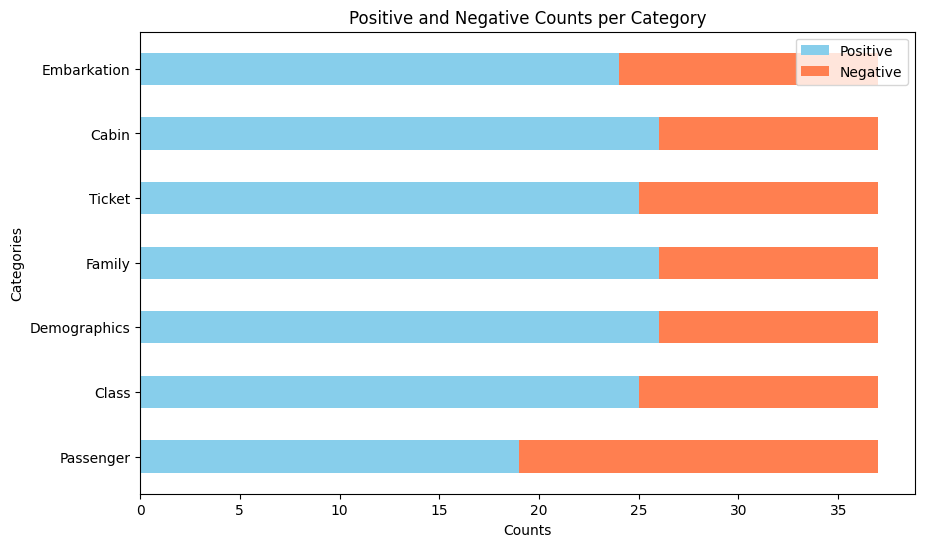

In [100]:
# for the whole test set - showing the positive/negative frequency of each ontology class

nodes_count = interpret(model, edge_index, ontology_mapping.keys())

In [53]:
model

OntologyNN(
  (selection): TopSelection(7, ratio=Parameter containing:
  tensor(1., requires_grad=True))
  (fc1): Linear(in_features=8, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dag_prop): DAGProp(1, 1, aggr=mean, nonlinearity=tanh)
  (gcn_prop): GCNPropagation(
    (conv1): GCNConv(7, 7)
  )
  (fc2): Linear(in_features=7, out_features=2, bias=True)
)

### A simple NN for baseline

In [ ]:
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
       # out = self.soft(out)
        return out


# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data['Survived'], test_size=0.2, random_state=42
)

X_train = torch.Tensor(X_train.values)
X_test = torch.Tensor(X_test.values)
y_train = torch.Tensor(y_train.values)
y_test = torch.Tensor(y_test.values)

# Hyperparameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 128
output_size = 1

# Initialize model, loss, and optimizer
model = TitanicNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

Epoch [50/500], Train Loss: 0.6201, Test Loss: 0.6511
Epoch [100/500], Train Loss: 0.5878, Test Loss: 0.6172
Epoch [150/500], Train Loss: 0.5583, Test Loss: 0.5886
Epoch [200/500], Train Loss: 0.5282, Test Loss: 0.5652
Epoch [250/500], Train Loss: 0.4978, Test Loss: 0.5469
Epoch [300/500], Train Loss: 0.4681, Test Loss: 0.5352
Epoch [350/500], Train Loss: 0.4405, Test Loss: 0.5310
Epoch [400/500], Train Loss: 0.4157, Test Loss: 0.5313
Epoch [450/500], Train Loss: 0.3944, Test Loss: 0.5359
Epoch [500/500], Train Loss: 0.3764, Test Loss: 0.5420


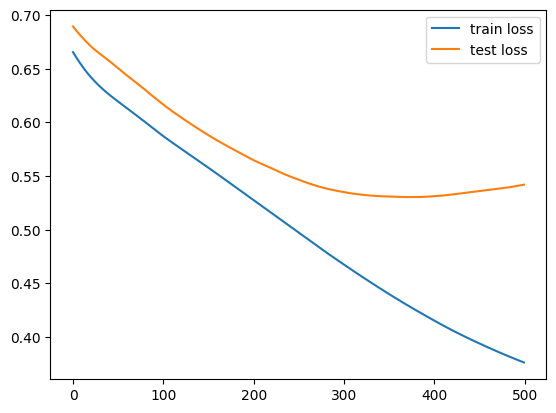

In [ ]:
train_losses = []
test_losses = []

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    output_train = model(X_train)
    target_train = y_train.unsqueeze(1)#torch.LongTensor(y_train.values)
    loss_train = criterion(output_train, target_train)
    loss_train.backward()
    optimizer.step()


    train_losses.append(loss_train.item())

    with torch.no_grad():
      output_test = model(X_test)
      target_test = y_test.unsqueeze(1)#torch.LongTensor(y_test.values)
      loss_test = criterion(output_test, target_test)
      test_losses.append(loss_test.item())

    # Step the scheduler based on the validation loss
    scheduler.step(loss_test)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')

plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "test loss")
plt.legend()
plt.show()

In [ ]:
# prompt: print the accuracy of predictions for train and test set

from sklearn.metrics import accuracy_score

# Predictions on the training set
with torch.no_grad():
    train_predictions = model(X_train)
    train_predicted_labels = torch.round(train_predictions)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    print(f"Train Accuracy: {train_accuracy}")

# Predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test)
    test_predicted_labels = torch.round(test_predictions)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.8493150684931506
Test Accuracy: 0.7027027027027027
